In [1]:
# Install required packages for Jupyter Notebook
!pip install dash seaborn pyproj folium scipy plotly
print("✓ Packages installed successfully!")

✓ Packages installed successfully!


In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyproj import Transformer
import plotly.express as px
import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output
import folium
from scipy import stats
import json

print("Libraries imported successfully!")

Libraries imported successfully!


In [6]:
import requests

csv_url = "https://raw.githubusercontent.com/dthomas1108/year4-data-visualisation-assignment/refs/heads/master/collision2017.csv"
r = requests.get(csv_url)

with open("collision2017.csv", "wb") as f:
    f.write(r.content)

print("✓ CSV data downloaded successfully!")

✓ CSV data downloaded successfully!


In [7]:
# Download GeoJSON file with individual collision points
geojson_url = "https://raw.githubusercontent.com/dthomas1108/year4-data-visualisation-assignment/refs/heads/master/collisions-2017.geojson"
r = requests.get(geojson_url)

with open("collisions-2017.geojson", "wb") as f:
    f.write(r.content)

print("✓ GeoJSON data downloaded successfully!")

# Load and parse the GeoJSON
with open('collisions-2017.geojson', 'r') as f:
    geojson_data = json.load(f)

print(f"✓ Loaded {len(geojson_data['features']):,} collision points from GeoJSON")

✓ GeoJSON data downloaded successfully!
✓ Loaded 6,081 collision points from GeoJSON


In [8]:
# Read collision data
df = pd.read_csv('collision2017.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
display(df.head())

# Basic statistics
print(f"\nBasic Statistics:")
print(df.describe())

Dataset Shape: (6081, 25)

Columns: ['a_year', 'a_ref', 'a_District', 'a_type', 'a_veh', 'a_cas', 'a_wkday', 'a_day', 'a_month', 'a_hour', 'a_min', 'a_gd1', 'a_gd2', 'a_ctype', 'a_speed', 'a_jdet', 'a_jcont', 'a_pedhum', 'a_pedphys', 'a_light', 'a_weat', 'a_roadsc', 'a_speccs', 'a_chaz', 'a_scene']

First few rows:


,a_year,a_ref,a_District,a_type,a_veh,a_cas,a_wkday,a_day,a_month,a_hour,...,a_jdet,a_jcont,a_pedhum,a_pedphys,a_light,a_weat,a_roadsc,a_speccs,a_chaz,a_scene
0,2017,1,NEMD,3,1,1,SUN,1,1,3,...,,,,,,,,,,
1,2017,2,MEAN,3,2,1,SUN,1,1,3,...,,,,,,,,,,
2,2017,3,ARBC,2,1,1,SUN,1,1,10,...,2,7,1,1,2,10,1,1,1,1
3,2017,4,ANTN,3,2,1,SUN,1,1,10,...,,,,,,,,,,
4,2017,5,ANTN,2,2,2,SUN,1,1,11,...,1,1,1,1,2,1,1,1,1,1



Basic Statistics:
       a_year        a_ref       a_type        a_veh        a_cas  \
count  6081.0  6081.000000  6081.000000  6081.000000  6081.000000   
mean   2017.0  3041.000000     2.873869     1.858083     1.510278   
std       0.0  1755.577825     0.361434     0.635119     0.987888   
min    2017.0     1.000000     1.000000     1.000000     1.000000   
25%    2017.0  1521.000000     3.000000     1.000000     1.000000   
50%    2017.0  3041.000000     3.000000     2.000000     1.000000   
75%    2017.0  4561.000000     3.000000     2.000000     2.000000   
max    2017.0  6081.000000     3.000000     8.000000    22.000000   

             a_day      a_month       a_hour        a_min          a_gd1  \
count  6081.000000  6081.000000  6081.000000  6081.000000    6081.000000   
mean     15.637066     6.703009    13.791646    27.897714  310065.191745   
std       8.780679     3.452060     4.942282    17.656101   33968.228173   
min       1.000000     1.000000     0.000000     0.0000

In [9]:
# Create a working copy
dfCol = df.copy()

# District mapping
district_mapping = {
    'ARBC': 'Armagh Banbridge and Craigavon',
    'BELC': 'Belfast',
    'CCGL': 'Causeway Coast and Glens',
    'ANTN': 'Antrim and Newtownabbey',
    'ARND': 'Ards and North Down',
    'DAST': 'Derry and Strabane',
    'DCST': 'Derry and Strabane',  # Alternative code
    'FMOC': 'Fermanagh and Omagh',
    'FERO': 'Fermanagh and Omagh',  # Alternative code
    'LISC': 'Lisburn and Castlereagh',
    'MEAN': 'Mid and East Antrim',
    'MEUL': 'Mid Ulster',
    'MIDU': 'Mid Ulster',  # Alternative code
    'NEMD': 'Newry Mourne and Down',
    'NOBD': 'North Down and Ards'
}

# Severity mapping
severity_mapping = {
    1: 'Fatal',
    2: 'Serious',
    3: 'Slight'
}

# Apply mappings
dfCol['District_Name'] = dfCol['a_District'].map(district_mapping)
dfCol['Severity'] = dfCol['a_type'].map(severity_mapping)

# Create datetime column
dfCol['datetime'] = pd.to_datetime(
    dfCol['a_year'].astype(str) + '-' + 
    dfCol['a_month'].astype(str) + '-' + 
    dfCol['a_day'].astype(str) + ' ' + 
    dfCol['a_hour'].astype(str) + ':' + 
    dfCol['a_min'].astype(str),
    format='%Y-%m-%d %H:%M'
)

print(f"✓ Cleaned CSV dataset shape: {dfCol.shape}")
print(f"\nSample of cleaned data:")
display(dfCol[['District_Name', 'Severity', 'a_cas', 'a_veh', 'datetime']].head())

✓ Cleaned CSV dataset shape: (6081, 28)

Sample of cleaned data:


,District_Name,Severity,a_cas,a_veh,datetime
0,Newry Mourne and Down,Slight,1,1,2017-01-01 03:28:00
1,Mid and East Antrim,Slight,1,2,2017-01-01 03:37:00
2,Armagh Banbridge and Craigavon,Serious,1,1,2017-01-01 10:26:00
3,Antrim and Newtownabbey,Slight,1,2,2017-01-01 10:56:00
4,Antrim and Newtownabbey,Serious,2,2,2017-01-01 11:57:00


In [10]:
# Convert GeoJSON features to DataFrame for mapping
collision_points = []
for feature in geojson_data['features']:
    props = feature['properties']
    coords = feature['geometry']['coordinates']
    
    # Create record with properties and coordinates
    record = props.copy()
    record['longitude'] = coords[0]
    record['latitude'] = coords[1]
    collision_points.append(record)

dfGeo = pd.DataFrame(collision_points)

# Apply same mappings to GeoJSON data
dfGeo['District_Name'] = dfGeo['a_District'].map(district_mapping)
dfGeo['Severity'] = dfGeo['a_type'].map(severity_mapping)

# Clean weather data (strip whitespace)
dfGeo['a_weat'] = dfGeo['a_weat'].astype(str).str.strip()

# Remove rows with missing coordinates
dfGeo = dfGeo.dropna(subset=['latitude', 'longitude'])

print(f"✓ Created GeoJSON DataFrame with {len(dfGeo):,} collision points")
print(f"\nSample GeoJSON data:")
display(dfGeo[['District_Name', 'Severity', 'latitude', 'longitude', 'a_hour', 'a_weat']].head())

✓ Created GeoJSON DataFrame with 6,081 collision points

Sample GeoJSON data:


,District_Name,Severity,latitude,longitude,a_hour,a_weat
0,Newry Mourne and Down,Slight,54.281742,-5.863640,3,
1,Mid and East Antrim,Slight,54.851131,-6.363452,3,
2,Armagh Banbridge and Craigavon,Serious,54.353228,-6.639651,10,10
3,Antrim and Newtownabbey,Slight,54.657811,-5.909253,10,
4,Antrim and Newtownabbey,Serious,54.743628,-6.235357,11,1


In [11]:
# Key statistics
print("=" * 60)
print("SAFER STREETS NI - 2017 COLLISION ANALYSIS")
print("=" * 60)

print(f"\nTotal Collisions: {len(dfCol):,}")
print(f"Total Casualties: {dfCol['a_cas'].sum():,}")
print(f"\nCollisions by Severity:")
print(dfCol['Severity'].value_counts())

print(f"\nCollisions by District:")
print(dfCol['District_Name'].value_counts())

# Time analysis
print(f"\nCollisions by Day of Week:")
print(dfCol['a_wkday'].value_counts())

print(f"\nCollisions by Month:")
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
dfCol['Month_Name'] = dfCol['a_month'].map(month_names)
print(dfCol['Month_Name'].value_counts().sort_index())

SAFER STREETS NI - 2017 COLLISION ANALYSIS

Total Collisions: 6,081
Total Casualties: 9,184

Collisions by Severity:
Severity
Slight     5376
Serious     643
Fatal        62
Name: count, dtype: int64

Collisions by District:
District_Name
Belfast                           1478
Armagh Banbridge and Craigavon     601
Newry Mourne and Down              574
Lisburn and Castlereagh            525
Antrim and Newtownabbey            471
Derry and Strabane                 449
Mid Ulster                         436
Ards and North Down                430
Causeway Coast and Glens           407
Mid and East Antrim                390
Fermanagh and Omagh                320
Name: count, dtype: int64

Collisions by Day of Week:
a_wkday
FRI    1032
WED     979
THU     959
TUE     843
SAT     821
MON     798
SUN     649
Name: count, dtype: int64

Collisions by Month:
Month_Name
Apr    405
Aug    517
Dec    534
Feb    461
Jan    475
Jul    493
Jun    496
Mar    515
May    522
Nov    561
Oct    529
Sep   

In [12]:
# 1. District-level aggregations (from CSV data)
district_stats = dfCol.groupby('District_Name').agg({
    'a_ref': 'count',
    'a_cas': 'sum',
    'a_type': lambda x: (x == 1).sum()
}).rename(columns={
    'a_ref': 'Total_Collisions',
    'a_cas': 'Total_Casualties',
    'a_type': 'Fatal_Collisions'
}).reset_index()

# 2. Severity breakdown by district
severity_by_district = dfCol.groupby(['District_Name', 'Severity']).size().reset_index(name='Count')

# 3. Temporal patterns
hourly_collisions = dfCol.groupby('a_hour').size().reset_index(name='Collisions')
monthly_collisions = dfCol.groupby('a_month').size().reset_index(name='Collisions')

month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
monthly_collisions['Month'] = monthly_collisions['a_month'].map(month_names)

# 4. Day of week analysis
dow_collisions = dfCol.groupby('a_wkday').size().reset_index(name='Collisions')
dow_order = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']
dow_collisions['a_wkday'] = pd.Categorical(dow_collisions['a_wkday'], categories=dow_order, ordered=True)
dow_collisions = dow_collisions.sort_values('a_wkday')

# 5. District center coordinates for reference
district_centers = {
    'Belfast': (54.5973, -5.9301),
    'Armagh Banbridge and Craigavon': (54.3520, -6.6530),
    'Causeway Coast and Glens': (55.1234, -6.6722),
    'Antrim and Newtownabbey': (54.7182, -6.2172),
    'Ards and North Down': (54.6021, -5.6980),
    'Derry and Strabane': (55.0090, -7.3598),
    'Fermanagh and Omagh': (54.4526, -7.6313),
    'Lisburn and Castlereagh': (54.5264, -6.0386),
    'Mid and East Antrim': (54.8638, -6.2766),
    'Mid Ulster': (54.5860, -6.7493),
    'Newry Mourne and Down': (54.1759, -6.3402)
}

# 6. Correlation matrix for analysis
numeric_cols = ['a_type', 'a_veh', 'a_cas', 'a_hour', 'a_month']
correlation_matrix = dfCol[numeric_cols].corr()

print("✓ Visualization data prepared successfully!")
print(f"\nDistrict Statistics:")
display(district_stats)

✓ Visualization data prepared successfully!

District Statistics:


,District_Name,Total_Collisions,Total_Casualties,Fatal_Collisions
0,Antrim and Newtownabbey,471,674,2
1,Ards and North Down,430,706,4
2,Armagh Banbridge and Craigavon,601,862,6
3,Belfast,1478,2143,3
4,Causeway Coast and Glens,407,648,6
5,Derry and Strabane,449,629,5
6,Fermanagh and Omagh,320,494,5
7,Lisburn and Castlereagh,525,848,7
8,Mid Ulster,436,659,5
9,Mid and East Antrim,390,597,6


In [13]:
# Create the Dash application with callback exception suppression
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = Dash(__name__, external_stylesheets=external_stylesheets, suppress_callback_exceptions=True)

# Define color scheme
colors = {
    'background': '#f8f9fa',
    'text': '#2c3e50',
    'primary': '#3498db',
    'danger': '#e74c3c',
    'warning': '#f39c12',
    'success': '#27ae60'
}

# Dashboard Layout
app.layout = html.Div([
    # Header
    html.Div([
        html.H1('Safer Streets NI Dashboard',
                style={'textAlign': 'center', 'color': colors['text'], 'marginBottom': 10}),
        html.H3('2017 Road Traffic Collision Analysis - Individual Collision Mapping',
                style={'textAlign': 'center', 'color': colors['primary'], 'marginTop': 0}),
        html.P('Team Barchart | Data Source: PSNI Road Policing',
               style={'textAlign': 'center', 'color': '#7f8c8d'}),
    ], style={'backgroundColor': colors['background'], 'padding': '20px'}),

    # Key Metrics Cards
    html.Div([
        html.Div([
            html.H4(f"{len(dfCol):,}", style={'color': colors['primary'], 'marginBottom': 5}),
            html.P('Total Collisions', style={'margin': 0})
        ], style={'textAlign': 'center', 'padding': '20px', 'backgroundColor': 'white',
                  'borderRadius': '5px', 'boxShadow': '2px 2px 5px rgba(0,0,0,0.1)',
                  'flex': '1', 'margin': '10px'}),

        html.Div([
            html.H4(f"{dfCol['a_cas'].sum():,}", style={'color': colors['warning'], 'marginBottom': 5}),
            html.P('Total Casualties', style={'margin': 0})
        ], style={'textAlign': 'center', 'padding': '20px', 'backgroundColor': 'white',
                  'borderRadius': '5px', 'boxShadow': '2px 2px 5px rgba(0,0,0,0.1)',
                  'flex': '1', 'margin': '10px'}),

        html.Div([
            html.H4(f"{(dfCol['a_type'] == 1).sum()}", style={'color': colors['danger'], 'marginBottom': 5}),
            html.P('Fatal Collisions', style={'margin': 0})
        ], style={'textAlign': 'center', 'padding': '20px', 'backgroundColor': 'white',
                  'borderRadius': '5px', 'boxShadow': '2px 2px 5px rgba(0,0,0,0.1)',
                  'flex': '1', 'margin': '10px'}),

        html.Div([
            html.H4(f"{len(dfCol['District_Name'].unique())}", style={'color': colors['success'], 'marginBottom': 5}),
            html.P('Districts Covered', style={'margin': 0})
        ], style={'textAlign': 'center', 'padding': '20px', 'backgroundColor': 'white',
                  'borderRadius': '5px', 'boxShadow': '2px 2px 5px rgba(0,0,0,0.1)',
                  'flex': '1', 'margin': '10px'}),
    ], style={'display': 'flex', 'flexWrap': 'wrap', 'justifyContent': 'space-around',
              'margin': '20px', 'padding': '10px'}),

    # Tabs for different visualizations
    dcc.Tabs(id='tabs', value='overview-tab', children=[
        dcc.Tab(label='📊 Overview', value='overview-tab'),
        dcc.Tab(label='🗺️ Geographic Analysis', value='geo-tab'),
        dcc.Tab(label='⏰ Temporal Patterns', value='time-tab'),
        dcc.Tab(label='📈 District Comparison', value='district-tab'),
        dcc.Tab(label='🔗 Correlation Analysis', value='correlation-tab'),
    ], style={'marginTop': '20px'}),

    html.Div(id='tab-content', style={'padding': '20px'})
], style={'fontFamily': 'Arial, sans-serif', 'backgroundColor': colors['background']})

print("✓ Dashboard layout created successfully!")

✓ Dashboard layout created successfully!


In [14]:
# Main callback for tab content
@app.callback(
    Output('tab-content', 'children'),
    Input('tabs', 'value')
)
def render_content(tab):
    if tab == 'overview-tab':
        # Overview Tab
        fig_severity = px.pie(
            dfCol,
            names='Severity',
            title='Collision Distribution by Severity',
            color='Severity',
            color_discrete_map={'Fatal': colors['danger'],
                                'Serious': colors['warning'],
                                'Slight': colors['success']},
            hole=0.3
        )
        fig_severity.update_layout(height=500)

        fig_vehicles = px.histogram(
            dfCol,
            x='a_veh',
            title='Number of Vehicles Involved in Collisions',
            labels={'a_veh': 'Number of Vehicles', 'count': 'Frequency'},
            nbins=10
        )
        fig_vehicles.update_layout(height=500)

        return html.Div([
            html.Div([
                html.Div([dcc.Graph(figure=fig_severity)], style={'flex': '1', 'padding': '10px'}),
                html.Div([dcc.Graph(figure=fig_vehicles)], style={'flex': '1', 'padding': '10px'}),
            ], style={'display': 'flex', 'flexWrap': 'wrap'})
        ])

    elif tab == 'geo-tab':
        # Geographic Analysis Tab with Filters - USES GEOJSON DATA
        return html.Div([
            html.H3('Individual Collision Point Mapping', style={'color': colors['text'], 'marginBottom': '20px'}),
            
            # Filter Controls
            html.Div([
                html.Div([
                    html.Label('Time of Day:', style={'fontWeight': 'bold', 'marginBottom': '5px'}),
                    dcc.Dropdown(
                        id='time-filter',
                        options=[
                            {'label': 'All Times', 'value': 'all'},
                            {'label': 'Morning (6-11)', 'value': 'morning'},
                            {'label': 'Afternoon (12-17)', 'value': 'afternoon'},
                            {'label': 'Evening (18-23)', 'value': 'evening'},
                            {'label': 'Night (0-5)', 'value': 'night'}
                        ],
                        value='all',
                        clearable=False,
                        style={'width': '100%'}
                    )
                ], style={'flex': '1', 'padding': '10px'}),
                
                html.Div([
                    html.Label('Severity:', style={'fontWeight': 'bold', 'marginBottom': '5px'}),
                    dcc.Dropdown(
                        id='severity-filter',
                        options=[
                            {'label': 'All Severities', 'value': 'all'},
                            {'label': 'Fatal', 'value': 'Fatal'},
                            {'label': 'Serious', 'value': 'Serious'},
                            {'label': 'Slight', 'value': 'Slight'}
                        ],
                        value='all',
                        clearable=False,
                        style={'width': '100%'}
                    )
                ], style={'flex': '1', 'padding': '10px'}),
                
                html.Div([
                    html.Label('Weather:', style={'fontWeight': 'bold', 'marginBottom': '5px'}),
                    dcc.Dropdown(
                        id='weather-filter',
                        options=[
                            {'label': 'All Weather', 'value': 'all'},
                            {'label': 'Fine (No Wind)', 'value': '1'},
                            {'label': 'Raining (No Wind)', 'value': '2'},
                            {'label': 'Snowing (No Wind)', 'value': '3'},
                            {'label': 'Fine + Wind', 'value': '4'},
                            {'label': 'Raining + Wind', 'value': '5'},
                            {'label': 'Snowing + Wind', 'value': '6'},
                            {'label': 'Fog/Mist', 'value': '7'},
                            {'label': 'Other', 'value': '8'},
                            {'label': 'Unknown', 'value': '9'}
                        ],
                        value='all',
                        clearable=False,
                        style={'width': '100%'}
                    )
                ], style={'flex': '1', 'padding': '10px'}),
                
                html.Div([
                    html.Label('District:', style={'fontWeight': 'bold', 'marginBottom': '5px'}),
                    dcc.Dropdown(
                        id='district-filter',
                        options=[{'label': 'All Districts', 'value': 'all'}] + 
                                [{'label': dist, 'value': dist} for dist in sorted(dfGeo['District_Name'].dropna().unique())],
                        value='all',
                        clearable=False,
                        style={'width': '100%'}
                    )
                ], style={'flex': '1', 'padding': '10px'}),
            ], style={'display': 'flex', 'flexWrap': 'wrap', 'backgroundColor': 'white',
                      'padding': '15px', 'borderRadius': '5px', 'marginBottom': '20px',
                      'boxShadow': '2px 2px 5px rgba(0,0,0,0.1)'}),
            
            html.Div(id='map-summary-stats', style={'marginBottom': '20px'}),
            dcc.Graph(id='filtered-map', style={'height': '700px'}),
            html.Hr(),
            dcc.Graph(id='filtered-district-bar')
        ])

    elif tab == 'time-tab':
        # Temporal Patterns Tab
        fig_hourly = px.line(
            hourly_collisions,
            x='a_hour',
            y='Collisions',
            title='Collision Patterns by Hour of Day',
            labels={'a_hour': 'Hour of Day', 'Collisions': 'Number of Collisions'},
            markers=True
        )
        fig_hourly.update_layout(height=400)
        fig_hourly.update_traces(line_color=colors['primary'], line_width=3)

        fig_monthly = px.bar(
            monthly_collisions,
            x='Month',
            y='Collisions',
            title='Monthly Collision Distribution',
            labels={'Collisions': 'Number of Collisions'},
            color='Collisions',
            color_continuous_scale='Viridis'
        )
        fig_monthly.update_layout(height=400, showlegend=False)

        fig_dow = px.bar(
            dow_collisions,
            x='a_wkday',
            y='Collisions',
            title='Collisions by Day of Week',
            labels={'a_wkday': 'Day of Week', 'Collisions': 'Number of Collisions'},
            color='Collisions',
            color_continuous_scale='RdYlGn_r'
        )
        fig_dow.update_layout(height=400, showlegend=False)

        return html.Div([
            dcc.Graph(figure=fig_hourly),
            html.Div([
                html.Div([dcc.Graph(figure=fig_monthly)], style={'flex': '1', 'padding': '10px'}),
                html.Div([dcc.Graph(figure=fig_dow)], style={'flex': '1', 'padding': '10px'}),
            ], style={'display': 'flex', 'flexWrap': 'wrap'})
        ])

    elif tab == 'district-tab':
        # District Comparison Tab
        fig_severity_district = px.bar(
            severity_by_district,
            x='District_Name',
            y='Count',
            color='Severity',
            title='Collision Severity Breakdown by District',
            labels={'Count': 'Number of Collisions', 'District_Name': 'District'},
            color_discrete_map={'Fatal': colors['danger'],
                                'Serious': colors['warning'],
                                'Slight': colors['success']},
            barmode='group'
        )
        fig_severity_district.update_layout(height=500, xaxis_tickangle=-45)

        fig_casualties = px.scatter(
            district_stats,
            x='Total_Collisions',
            y='Total_Casualties',
            size='Fatal_Collisions',
            hover_name='District_Name',
            title='Collision vs Casualties Relationship (Bubble size = Fatal Collisions)',
            labels={'Total_Collisions': 'Total Collisions', 'Total_Casualties': 'Total Casualties'},
            trendline='ols'
        )
        fig_casualties.update_layout(height=500)

        return html.Div([
            dcc.Graph(figure=fig_severity_district),
            html.Hr(),
            dcc.Graph(figure=fig_casualties)
        ])
    
    elif tab == 'correlation-tab':
        # Correlation Analysis Tab
        var_name_mapping = {
            'a_type': 'Severity Type',
            'a_veh': 'Number of Vehicles',
            'a_cas': 'Number of Casualties',
            'a_hour': 'Hour of Day',
            'a_month': 'Month'
        }
        
        fig_heatmap = px.imshow(
            correlation_matrix,
            labels=dict(x="Variable", y="Variable", color="Correlation"),
            x=[var_name_mapping.get(col, col) for col in numeric_cols],
            y=[var_name_mapping.get(col, col) for col in numeric_cols],
            color_continuous_scale='Blues',
            title='Correlation Matrix Heatmap',
            text_auto='.2f',
            aspect="auto"
        )
        fig_heatmap.update_xaxes(side="bottom")
        fig_heatmap.update_layout(height=600, width=700)
        
        return html.Div([
            html.Div([dcc.Graph(figure=fig_heatmap)], style={'marginBottom': '30px'}),
            html.Hr(),
            html.Div([
                html.H3('Interactive Correlation Explorer', style={'color': colors['text'], 'marginTop': '20px'}),
                html.P('Select a variable to see its correlation with all other variables:',
                       style={'color': '#7f8c8d', 'marginBottom': '15px'}),
                html.Label('Select Variable:', style={'fontWeight': 'bold', 'marginBottom': '10px'}),
                dcc.Dropdown(
                    id='correlation-dropdown',
                    options=[{'label': var_name_mapping.get(col, col), 'value': col} 
                             for col in numeric_cols],
                    value='a_cas',
                    style={'width': '50%', 'marginBottom': '20px'}
                ),
                dcc.Graph(id='correlation-graph')
            ], style={'backgroundColor': 'white', 'padding': '20px', 'borderRadius': '5px',
                      'boxShadow': '2px 2px 5px rgba(0,0,0,0.1)'})
        ])

print("✓ Main callback defined successfully!")

✓ Main callback defined successfully!


In [15]:
# Callback for filtered map with INDIVIDUAL COLLISION POINTS from GeoJSON
@app.callback(
    [Output('filtered-map', 'figure'),
     Output('filtered-district-bar', 'figure'),
     Output('map-summary-stats', 'children')],
    [Input('time-filter', 'value'),
     Input('severity-filter', 'value'),
     Input('weather-filter', 'value'),
     Input('district-filter', 'value')]
)
def update_map(time_period, severity, weather, district):
    # Use GeoJSON data for individual collision points
    filtered_df = dfGeo.copy()
    
    # Apply Time Filter
    if time_period != 'all':
        if time_period == 'morning':
            filtered_df = filtered_df[(filtered_df['a_hour'] >= 6) & (filtered_df['a_hour'] <= 11)]
        elif time_period == 'afternoon':
            filtered_df = filtered_df[(filtered_df['a_hour'] >= 12) & (filtered_df['a_hour'] <= 17)]
        elif time_period == 'evening':
            filtered_df = filtered_df[(filtered_df['a_hour'] >= 18) & (filtered_df['a_hour'] <= 23)]
        elif time_period == 'night':
            filtered_df = filtered_df[(filtered_df['a_hour'] >= 0) & (filtered_df['a_hour'] <= 5)]
    
    # Apply Severity Filter
    if severity != 'all':
        filtered_df = filtered_df[filtered_df['Severity'] == severity]
    
    # Apply Weather Filter
    if weather != 'all':
        filtered_df = filtered_df[filtered_df['a_weat'] == weather]
    
    # Apply District Filter
    if district != 'all':
        filtered_df = filtered_df[filtered_df['District_Name'] == district]
    
    # Create map with individual collision points
    if len(filtered_df) > 0:
        # Sample if too many points (for performance)
        if len(filtered_df) > 2000:
            display_df = filtered_df.sample(n=2000, random_state=42)
            title_suffix = f" (showing 2000 of {len(filtered_df):,} collisions)"
        else:
            display_df = filtered_df
            title_suffix = f" ({len(filtered_df):,} collisions)"
        
        fig_map = px.scatter_mapbox(
            display_df,
            lat='latitude',
            lon='longitude',
            color='Severity',
            hover_data={
                'District_Name': True,
                'a_hour': True,
                'a_weat': True,
                'a_veh': True,
                'latitude': False,
                'longitude': False
            },
            title=f'Individual Collision Locations{title_suffix}',
            color_discrete_map={
                'Fatal': colors['danger'],
                'Serious': colors['warning'],
                'Slight': colors['success']
            },
            zoom=7,
            opacity=0.7,
            size_max=8
        )
        fig_map.update_layout(
            mapbox_style='carto-positron',
            height=700,
            margin={'r': 0, 't': 40, 'l': 0, 'b': 0}
        )
    else:
        fig_map = go.Figure()
        fig_map.update_layout(title='No data matches the selected filters', height=700)
    
    # Recalculate district statistics for bar chart
    filtered_district_stats = filtered_df.groupby('District_Name').agg({
        'a_ref': 'count',
        'a_cas': 'sum',
        'a_type': lambda x: (x == 1).sum()
    }).rename(columns={
        'a_ref': 'Total_Collisions',
        'a_cas': 'Total_Casualties',
        'a_type': 'Fatal_Collisions'
    }).reset_index()
    
    # Create bar chart
    if len(filtered_district_stats) > 0:
        fig_bar = px.bar(
            filtered_district_stats.sort_values('Total_Collisions', ascending=True),
            x='Total_Collisions',
            y='District_Name',
            orientation='h',
            title='Total Collisions by District (Filtered)',
            labels={'Total_Collisions': 'Number of Collisions', 'District_Name': 'District'},
            color='Total_Collisions',
            color_continuous_scale='Blues'
        )
        fig_bar.update_layout(height=500, showlegend=False)
    else:
        fig_bar = go.Figure()
        fig_bar.update_layout(title='No data matches the selected filters', height=500)
    
    # Create summary stats
    summary = html.Div([
        html.Div([
            html.Div([
                html.H4(f"{len(filtered_df):,}", style={'color': colors['primary'], 'marginBottom': 5}),
                html.P('Filtered Collisions', style={'margin': 0, 'fontSize': '14px'})
            ], style={'textAlign': 'center', 'padding': '15px', 'backgroundColor': 'white',
                      'borderRadius': '5px', 'boxShadow': '2px 2px 5px rgba(0,0,0,0.1)',
                      'flex': '1', 'margin': '5px'}),
            html.Div([
                html.H4(f"{filtered_df['a_cas'].sum():,}", style={'color': colors['warning'], 'marginBottom': 5}),
                html.P('Total Casualties', style={'margin': 0, 'fontSize': '14px'})
            ], style={'textAlign': 'center', 'padding': '15px', 'backgroundColor': 'white',
                      'borderRadius': '5px', 'boxShadow': '2px 2px 5px rgba(0,0,0,0.1)',
                      'flex': '1', 'margin': '5px'}),
            html.Div([
                html.H4(f"{(filtered_df['a_type'] == 1).sum()}", style={'color': colors['danger'], 'marginBottom': 5}),
                html.P('Fatal Collisions', style={'margin': 0, 'fontSize': '14px'})
            ], style={'textAlign': 'center', 'padding': '15px', 'backgroundColor': 'white',
                      'borderRadius': '5px', 'boxShadow': '2px 2px 5px rgba(0,0,0,0.1)',
                      'flex': '1', 'margin': '5px'}),
            html.Div([
                html.H4(f"{len(filtered_df['District_Name'].unique())}", style={'color': colors['success'], 'marginBottom': 5}),
                html.P('Districts Affected', style={'margin': 0, 'fontSize': '14px'})
            ], style={'textAlign': 'center', 'padding': '15px', 'backgroundColor': 'white',
                      'borderRadius': '5px', 'boxShadow': '2px 2px 5px rgba(0,0,0,0.1)',
                      'flex': '1', 'margin': '5px'}),
        ], style={'display': 'flex', 'flexWrap': 'wrap', 'justifyContent': 'space-around'})
    ])
    
    return fig_map, fig_bar, summary

print("✓ Map filter callback defined successfully!")

✓ Map filter callback defined successfully!


In [16]:
# Callback for correlation dropdown
@app.callback(
    Output('correlation-graph', 'figure'),
    Input('correlation-dropdown', 'value')
)
def update_correlation(selected_var):
    var_name_mapping = {
        'a_type': 'Severity Type',
        'a_veh': 'Number of Vehicles',
        'a_cas': 'Number of Casualties',
        'a_hour': 'Hour of Day',
        'a_month': 'Month'
    }
    
    correlations = correlation_matrix[selected_var].sort_values(ascending=False)
    
    fig = px.bar(
        x=[var_name_mapping.get(col, col) for col in correlations.index],
        y=correlations.values,
        title=f'Correlation with {var_name_mapping.get(selected_var, selected_var)}',
        labels={'x': 'Variables', 'y': 'Correlation Coefficient'},
        color=correlations.values,
        color_continuous_scale='RdBu',
        color_continuous_midpoint=0
    )
    
    fig.update_layout(height=500, showlegend=False, xaxis_tickangle=-45)
    fig.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5)
    
    return fig

print("✓ Correlation callback defined successfully!")

✓ Correlation callback defined successfully!


In [17]:
# Run the dashboard
if __name__ == '__main__':
    # For Google Colab, use 'external' mode
    app.run(jupyter_mode='external', debug=True, port=8050)
    # app.run(jupyter_mode='inline', debug=True, port=8050, height=800)

    # For Jupyter Notebook/Lab, use 'inline' or 'jupyterlab' mode
    # app.run_server(mode='inline', debug=True, port=8050, height=800)

    # Available modes:
    # - 'inline': Display dashboard inline in notebook
    # - 'external': Open in new browser tab (best for Colab)
    # - 'jupyterlab': For JupyterLab users
    # - 'tab': Open in new browser tab (for desktop)

Dash app running on http://127.0.0.1:8050/


C:\Users\dylan\AppData\Local\Temp\ipykernel_7140\3855617820.py:48: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

C:\Users\dylan\AppData\Local\Temp\ipykernel_7140\3855617820.py:48: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

C:\Users\dylan\AppData\Local\Temp\ipykernel_7140\3855617820.py:48: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

C:\Users\dylan\AppData\Local\Temp\ipykernel_7140\3855617820.py:48: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

C:\Users\dylan\AppData\Local\Temp\ipykernel_7140\3855617820.py:48: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: ht

Correlation Analysis


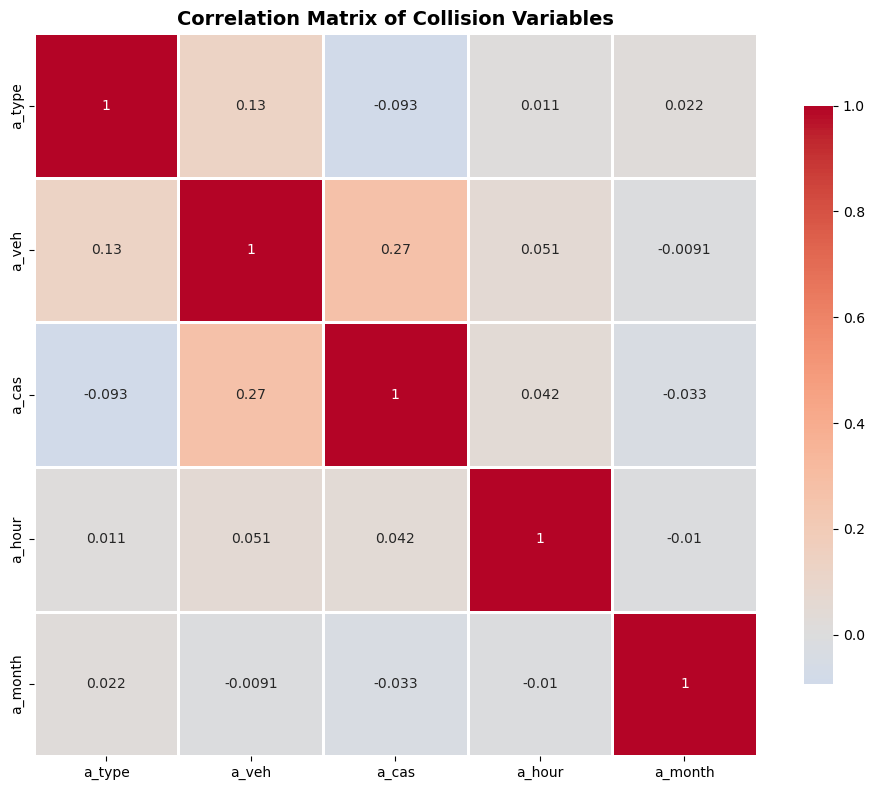


Key Findings:
- Vehicles vs Casualties correlation: 0.272
- Severity vs Casualties correlation: -0.093


In [18]:
# Correlation Analysis
print("Correlation Analysis")
print("=" * 60)

# Select numeric columns for correlation
numeric_cols = ['a_type', 'a_veh', 'a_cas', 'a_hour', 'a_month']
correlation_matrix = dfCol[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Collision Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nKey Findings:")
print(f"- Vehicles vs Casualties correlation: {dfCol['a_veh'].corr(dfCol['a_cas']):.3f}")
print(f"- Severity vs Casualties correlation: {dfCol['a_type'].corr(dfCol['a_cas']):.3f}")

In [19]:
# Chi-square test: Severity vs District
print("Statistical Test: Severity Distribution Across Districts")
print("=" * 60)

contingency_table = pd.crosstab(dfCol['District_Name'], dfCol['Severity'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"\nChi-square statistic: {chi2:.2f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")

if p_value < 0.05:
    print("\n✓ Result: Severity distribution SIGNIFICANTLY differs across districts (p < 0.05)")
else:
    print("\n✗ Result: No significant difference in severity distribution across districts")

print("\nContingency Table:")
display(contingency_table)

Statistical Test: Severity Distribution Across Districts

Chi-square statistic: 52.65
P-value: 0.0001
Degrees of freedom: 20

✓ Result: Severity distribution SIGNIFICANTLY differs across districts (p < 0.05)

Contingency Table:


Severity,Fatal,Serious,Slight
District_Name,,,
Antrim and Newtownabbey,2,47,422
Ards and North Down,4,44,382
Armagh Banbridge and Craigavon,6,66,529
Belfast,3,123,1352
Causeway Coast and Glens,6,53,348
Derry and Strabane,5,37,407
Fermanagh and Omagh,5,41,274
Lisburn and Castlereagh,7,47,471
Mid Ulster,5,55,376
